C:\Users\aafaq\AppData\Local\Temp\ipykernel_2156\1438599853.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2024-01-01")[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed


Epoch 1/30 — Train Loss: 0.0238  Val Loss: 1.1442
Epoch 2/30 — Train Loss: 0.0012  Val Loss: 0.2067
Epoch 3/30 — Train Loss: 0.0011  Val Loss: 0.1097
Epoch 4/30 — Train Loss: 0.0008  Val Loss: 0.1164
Epoch 5/30 — Train Loss: 0.0022  Val Loss: 0.1036
Epoch 6/30 — Train Loss: 0.0020  Val Loss: 0.1023
Epoch 7/30 — Train Loss: 0.0011  Val Loss: 0.1064
Epoch 8/30 — Train Loss: 0.0006  Val Loss: 0.0965
Epoch 9/30 — Train Loss: 0.0007  Val Loss: 0.0810
Epoch 10/30 — Train Loss: 0.0016  Val Loss: 0.0760
Epoch 11/30 — Train Loss: 0.0008  Val Loss: 0.1146
Epoch 12/30 — Train Loss: 0.0006  Val Loss: 0.0914
Epoch 13/30 — Train Loss: 0.0014  Val Loss: 0.1181
Epoch 14/30 — Train Loss: 0.0011  Val Loss: 0.0694
Epoch 15/30 — Train Loss: 0.0007  Val Loss: 0.1024
Epoch 16/30 — Train Loss: 0.0011  Val Loss: 0.0853
Epoch 17/30 — Train Loss: 0.0016  Val Loss: 0.0706
Epoch 18/30 — Train Loss: 0.0006  Val Loss: 0.0608
Epoch 19/30 — Train Loss: 0.0007  Val Loss: 0.0728
Epoch 20/30 — Train Loss: 0.0006  Val Lo

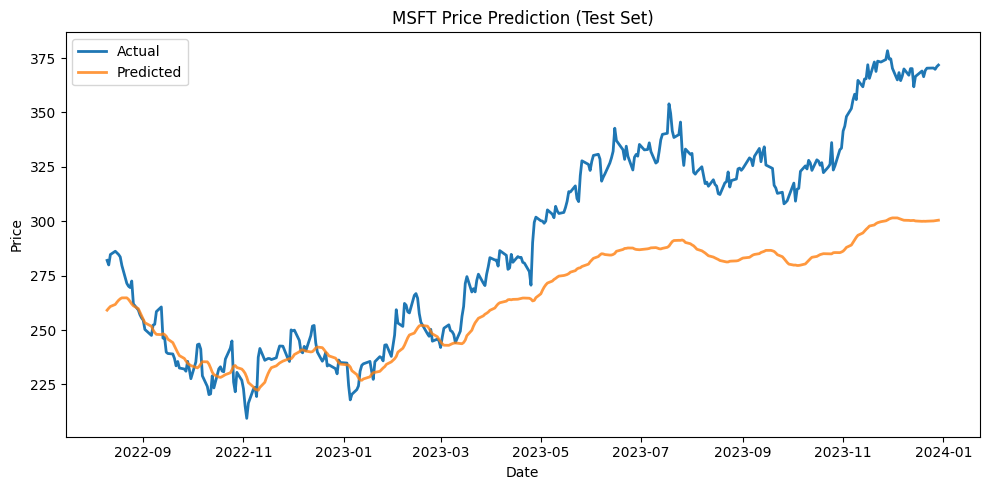

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from math import sqrt

# 1) Download data
ticker = "MSFT"
df = yf.download(ticker, start="2010-01-01", end="2024-01-01")[['Close']].dropna()

# 2) Scale
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)

# 3) Build sequences
SEQ_LEN = 30
X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i, 0])
    y.append(scaled[i, 0])
X = np.array(X);  y = np.array(y)

# 4) Chronological split: 80% train, 10% val, 10% test
n = len(X)
train_end = int(n * 0.8)
val_end   = int(n * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],    y[val_end:]

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq, 1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    def __len__(self):  return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_dl = DataLoader(StockDataset(X_train, y_train), batch_size=64, shuffle=True)
val_dl   = DataLoader(StockDataset(X_val, y_val),     batch_size=64)
test_dl  = DataLoader(StockDataset(X_test, y_test),   batch_size=1)

# 5) LSTM Model with a bit more capacity
class LSTMModel(nn.Module):
    def __init__(self, in_size=1, hid_size=64, nlayers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(in_size, hid_size, nlayers, 
                            batch_first=True, dropout=dropout)
        self.out  = nn.Linear(hid_size, 1)
    def forward(self, x):
        # x: (B, T, 1)
        out, _ = self.lstm(x)           
        return self.out(out[:, -1, :])  # last time-step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.MSELoss()

# 6) Training loop with val monitoring
EPOCHS = 30
best_val = float('inf')
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = crit(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    # validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_losses.append(crit(model(xb), yb).item())
    val_loss = np.mean(val_losses)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    print(f"Epoch {ep}/{EPOCHS} — Train Loss: {loss.item():.4f}  Val Loss: {val_loss:.4f}")

# load best
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 7) Predict on test set
preds, reals = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        p = model(xb).cpu().numpy().ravel()[0]
        preds.append(p); reals.append(yb.item())

# inverse scale
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()
reals = scaler.inverse_transform(np.array(reals).reshape(-1,1)).ravel()

# compute RMSE
rmse = sqrt(mean_squared_error(reals, preds))
print(f"\nTest RMSE: {rmse:.2f}")

# 8) Plot only the test window, with dates
dates = df.index[SEQ_LEN+val_end : SEQ_LEN+val_end + len(preds)]

plt.figure(figsize=(10,5))
plt.plot(dates, reals, label='Actual', linewidth=2)
plt.plot(dates, preds, label='Predicted', linewidth=2, alpha=0.8)
plt.title(f'{ticker} Price Prediction (Test Set)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.tight_layout()
plt.show()
